In [1]:
from configparser import ConfigParser
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris
from collections import Counter 
import datetime
import pickle
import time
import os





In [2]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql_sample.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [3]:
cfg = config()

In [3]:
#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
#     conn = psycopg2.connect(**cfg)
    conn = psycopg2.connect(
        host="www.eecs.uottawa.ca",
        database="group_22",
        user="yzhao156",
        password="UozonePassword",
        port=15432
    )
    cursor = conn.cursor()
    print("Look's like it was a success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [4]:
try:
    #Lets get our data 
    cursor.execute(
    """
SELECT D.month as month,  S.title as special_measure, 
    P.Age_Group as Age_Group, P.client_gender as gender, 
    M.parks_percent_change_from_baseline as mobility,
    F.fatal as fatal
FROM covid19_tracking_fact_table F, 
    date_dimension D, 
    mobility_dimension M,
    special_measures_dimension S,
    patient_dimension P
WHERE F.reported_date_key = D.surrogate_key AND
    F.special_measure_key = S.surrogate_key AND
    F.mobility_key = M.surrogate_key AND
    F.patient_key = P.surrogate_key 
ORDER BY D.date
    """    
        
                  
    
    )

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [5]:
cursor.close()
conn.close()

In [6]:
data = pd.DataFrame(result_list,columns=["month", "special_measure",
                "Age_Group", "gender", "mobility", "fatal"])

In [7]:
data.head()

,month,special_measure,Age_Group,gender,mobility,fatal
0,11,Restrict,40s,MALE,-26.0,0
1,11,Restrict,30s,MALE,-26.0,0
2,11,Restrict,50s,MALE,-26.0,0
3,11,Restrict,<20,FEMALE,-26.0,0
4,11,Restrict,30s,FEMALE,-26.0,0


In [8]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( data, open( "./saves/data.p", "wb" ) )

In [33]:
data = pickle.load( open( "./saves/data.p", "rb" ) )

In [34]:
data

,month,special_measure,Age_Group,gender,mobility,fatal
0,11,Restrict,40s,MALE,-26.0,0
1,11,Restrict,30s,MALE,-26.0,0
2,11,Restrict,50s,MALE,-26.0,0
3,11,Restrict,<20,FEMALE,-26.0,0
4,11,Restrict,30s,FEMALE,-26.0,0
...,...,...,...,...,...,...
147899,2,Control,<20,FEMALE,-23.0,0
147900,2,Control,20s,MALE,-23.0,0
147901,2,Control,20s,FEMALE,-23.0,0
147902,2,Control,50s,FEMALE,-23.0,0


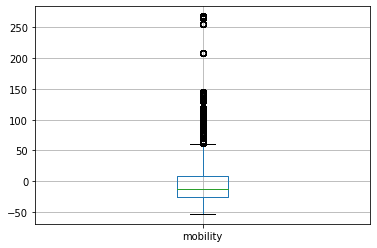

In [35]:
data.boxplot(column=['mobility'])

(array([6.49280013e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.20857974e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.59857445e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.63944180e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.27057791e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.08883841e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.40391365e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.98356892e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.54543488e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.60594259e-04]),
 array([0.   , 0.225, 0.45 , 0.675, 0.9  , 1.125, 1.35 , 1.575, 1.8  ,
        2.025, 2.25 , 2.475, 2.7  , 2.925, 3.15 , 3.375, 3.6  , 3.825,
        4.05 , 4.275, 4.5  , 4.725, 4.95 , 5.175, 5.4  , 5.625, 5.85 ,
        6.075, 6.3  , 6.525, 6.75 , 6.975, 7.2  , 7.425, 7.65 , 7

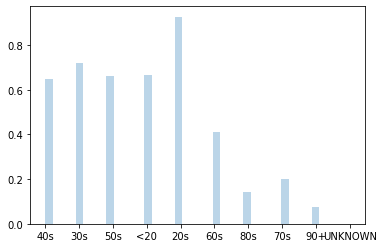

In [36]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
plt.hist(data['Age_Group'], **kwargs)

# A.2

In [37]:
data.head()

,month,special_measure,Age_Group,gender,mobility,fatal
0,11,Restrict,40s,MALE,-26.0,0
1,11,Restrict,30s,MALE,-26.0,0
2,11,Restrict,50s,MALE,-26.0,0
3,11,Restrict,<20,FEMALE,-26.0,0
4,11,Restrict,30s,FEMALE,-26.0,0


In [38]:
data.isna().sum()

month              0
special_measure    0
Age_Group          0
gender             0
mobility           0
fatal              0
dtype: int64

In [39]:
data = data[data['Age_Group']!="UNKNOWN"]

In [40]:
data['Age_Group'].drop_duplicates()

0      40s
1      30s
2      50s
3      <20
7      20s
11     60s
37     80s
44     70s
518    90+
Name: Age_Group, dtype: object

In [41]:
mapping_age = {
    '<20':0,
    '20s':1,
    '30s':2,
    '40s':3,
    '50s':4,
    '60s':5,
    '70s':6,
    '80s':7,
    '90+':8
}
data['Age_Group'] = data['Age_Group'].map(lambda x : mapping_age[x])
    

/Users/yi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [42]:
mapping_month = {
    11:1,
    12:2,
    1:3,
    2:4
}
data['month'] = data['month'].map(lambda x : mapping_month[x])

/Users/yi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [44]:
mapping_gender = {
    'MALE':0,
    'FEMALE':1,
    'UNSPECIFIED':2,
    'GENDER DIVERSE':3
}
data['gender'] = data['gender'].map(lambda x : mapping_gender[x])


KeyError: 0

In [45]:
data[data['gender']==3]['gender'].count()

12

In [46]:
data[data['gender']==2]['gender'].count()

626

In [47]:
data[data['gender']==1]['gender'].count()

73283

In [48]:
data = data[data['gender']<2]

In [49]:
one_hot = pd.get_dummies(data.special_measure, prefix='special_measure')
one_hot.shape

(147254, 5)

In [50]:
data.shape

(147254, 6)

In [51]:
data = pd.concat([data,one_hot],axis=1)

In [52]:
data = data.drop(columns=['special_measure'])

In [53]:
data

,month,Age_Group,gender,mobility,fatal,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
0,1,3,0,-26.0,0,0,0,0,0,1
1,1,2,0,-26.0,0,0,0,0,0,1
2,1,4,0,-26.0,0,0,0,0,0,1
3,1,0,1,-26.0,0,0,0,0,0,1
4,1,2,1,-26.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
147899,4,0,1,-23.0,0,1,0,0,0,0
147900,4,1,0,-23.0,0,1,0,0,0,0
147901,4,1,1,-23.0,0,1,0,0,0,0
147902,4,4,1,-23.0,0,1,0,0,0,0


### normalisation

In [54]:
#normalize mobility
data['mobility'] = (data['mobility']-data['mobility'].min())/(data['mobility'].max()-data['mobility'].min())
data['Age_Group'] = (data['Age_Group']-data['Age_Group'].min())/(data['Age_Group'].max()-data['Age_Group'].min())
data['month'] = (data['month']-data['month'].min())/(data['month'].max()-data['month'].min())

In [55]:
data

,month,Age_Group,gender,mobility,fatal,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
0,0.0,0.375,0,0.084112,0,0,0,0,0,1
1,0.0,0.250,0,0.084112,0,0,0,0,0,1
2,0.0,0.500,0,0.084112,0,0,0,0,0,1
3,0.0,0.000,1,0.084112,0,0,0,0,0,1
4,0.0,0.250,1,0.084112,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
147899,1.0,0.000,1,0.093458,0,1,0,0,0,0
147900,1.0,0.125,0,0.093458,0,1,0,0,0,0
147901,1.0,0.125,1,0.093458,0,1,0,0,0,0
147902,1.0,0.500,1,0.093458,0,1,0,0,0,0


In [56]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( data, open( "./saves/prereocessed_data.p", "wb" ) )

In [57]:
data = pickle.load( open( "./saves/prereocessed_data.p", "rb" ) )

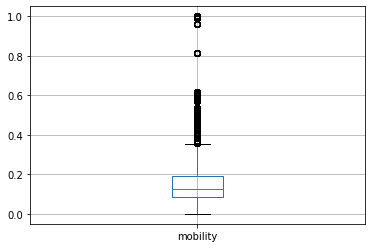

In [58]:
data.boxplot(column=['mobility'])

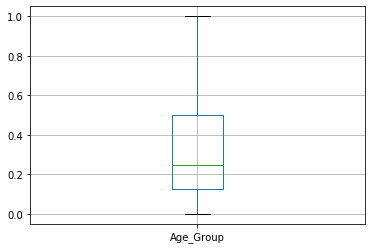

In [59]:
data.boxplot(column=['Age_Group'])

### undersampling

In [61]:
shuffle_unresolved = shuffle(data[data['fatal']==0])
shuffle_resolved = shuffle(data[data['fatal']==1])
shuffle_resolved = shuffle_resolved[:len(shuffle_unresolved)]
undersampled_data = shuffle_resolved.append(shuffle_unresolved)
undersampled_data = shuffle(undersampled_data)

In [62]:
len(undersampled_data)

147254

In [63]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( undersampled_data, open( "./saves/undersampled_data.p", "wb" ) )

In [64]:
undersampled_data.describe()

,month,Age_Group,gender,mobility,fatal,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
count,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000
mean,0.479213,0.331319,0.497664,0.154145,0.012753,0.185890,0.217977,0.223213,0.122333,0.250587
std,0.326122,0.252127,0.499996,0.108316,0.112209,0.389019,0.412873,0.416401,0.327671,0.433353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.125000,0.000000,0.084112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.333333,0.250000,0.000000,0.124611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.500000,1.000000,0.193146,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


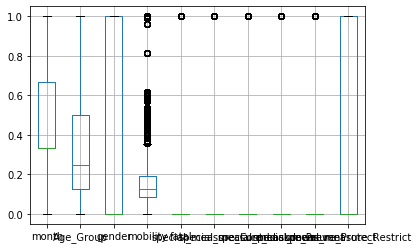

In [65]:
undersampled_data.boxplot(column=undersampled_data.columns.values.tolist())

# Part B

## Decision Tree

In [2]:
undersampled_data = pickle.load( open( "./saves/undersampled_data.p", "rb" ) )

In [3]:
data = pickle.load( open( "./saves/undersampled_data.p", "rb" ) )

In [66]:
column_list = data.columns.values.tolist()
column_list.remove('fatal')
column_list

['month',
 'Age_Group',
 'gender',
 'mobility',
 'special_measure_Control',
 'special_measure_Lockdown',
 'special_measure_Prevent',
 'special_measure_Protect',
 'special_measure_Restrict']

In [67]:
# split the train and test data
X = undersampled_data[column_list]
y = undersampled_data['fatal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

|--- Age_Group <= 0.56
|   |--- class: 0
|--- Age_Group >  0.56
|   |--- Age_Group <= 0.69
|   |   |--- class: 0
|   |--- Age_Group >  0.69
|   |   |--- class: 1



[Text(133.92000000000002, 181.2, 'X[1] <= 0.562\nentropy = 1.0\nsamples = 110440\nvalue = [55220.0, 55220.0]'),
 Text(66.96000000000001, 108.72, 'entropy = 0.308\nsamples = 90032\nvalue = [45556.703, 2657.859]'),
 Text(200.88000000000002, 108.72, 'X[1] <= 0.688\nentropy = 0.623\nsamples = 20408\nvalue = [9663.297, 52562.141]'),
 Text(133.92000000000002, 36.23999999999998, 'entropy = 1.0\nsamples = 10083\nvalue = [5042.051, 4998.362]'),
 Text(267.84000000000003, 36.23999999999998, 'entropy = 0.432\nsamples = 10325\nvalue = [4621.247, 47563.779]')]

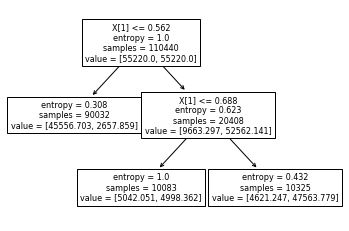

In [68]:
#Train the data
decision_tree = DecisionTreeClassifier(class_weight='balanced',criterion='entropy',max_depth=4,
            max_features=None,max_leaf_nodes=3,min_impurity_decrease=1e-04,min_samples_leaf=1,
            min_samples_split=2,min_weight_fraction_leaf=0.0,random_state=0,splitter='best')
start = time.time()
decision_tree = decision_tree.fit(X_train, y_train)
time_took = time.time()-start
#show the decision condiction and the structure of the tree
final_condiction= export_text(decision_tree, feature_names=column_list)
print(final_condiction)
tree.plot_tree(decision_tree) 

In [69]:
#eveulate the result
y_pred_tree=decision_tree.predict(X_test)
print (confusion_matrix(y_test,y_pred_tree))
print(classification_report(y_test,y_pred_tree))
print("Time to Train {:.2f} s".format(time_took))

[[33336  2992]
 [   66   420]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     36328
           1       0.12      0.86      0.22       486

    accuracy                           0.92     36814
   macro avg       0.56      0.89      0.59     36814
weighted avg       0.99      0.92      0.95     36814

Time to Train 0.09 s


 ## Gradient Boosting  

In [70]:
#find the best learning rate
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
best_rate=lr_list[0]
best_accuracy=0
for learning_rate in lr_list:
    gradientBoosting = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gradientBoosting.fit(X_train, y_train)
    if gradientBoosting.score(X_test, y_test)>best_accuracy:
        best_accuracy=gradientBoosting.score(X_test, y_test)
        best_rate=learning_rate

In [71]:
#Using the best learning rate to train the model
gradientBoosting = GradientBoostingClassifier(n_estimators=20, learning_rate=best_accuracy, max_features=2, max_depth=2, random_state=0)
start = time.time()
gradientBoosting.fit(X_train, y_train)
time_took = time.time()-start
#eveulate the result
y_pred_boosting = gradientBoosting.predict(X_test)
print (confusion_matrix(y_test,y_pred_boosting))
print(classification_report(y_test,y_pred_boosting))
print("Time to Train {:.2f} s".format(time_took))

[[35121  1207]
 [  481     5]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     36328
           1       0.00      0.01      0.01       486

    accuracy                           0.95     36814
   macro avg       0.50      0.49      0.49     36814
weighted avg       0.97      0.95      0.96     36814

Time to Train 0.50 s


 ## Random Forest

In [72]:
#training part
randomForest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', max_depth=4, random_state=0,
                                      max_features='sqrt',max_leaf_nodes=3,min_impurity_decrease=1e-04,
                                      min_samples_leaf=1,min_samples_split=2)
start = time.time()
randomForest.fit(X_train,y_train)
time_took = time.time()-start
#show the decision condiction and the structure of the tree

#Estimators = classifier.estimators_
#for index, model in enumerate(Estimators):
    #each_condiction= export_text(model, feature_names=['Age_Group', 'Client_Gender', 'mobility', 'Special_Measures_Control', 'Special_Measures_Lockdown', 'Special_Measures_Protect', 'Special_Measures_Restrict'])
    #print(each_condiction)


In [73]:
#eveulate the result
y_pred_forest = randomForest.predict(X_test)
print (confusion_matrix(y_test,y_pred_forest))
print(classification_report(y_test,y_pred_forest))
print("Time to Train {:.2f} s".format(time_took))

[[36328     0]
 [  486     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     36328
           1       0.00      0.00      0.00       486

    accuracy                           0.99     36814
   macro avg       0.49      0.50      0.50     36814
weighted avg       0.97      0.99      0.98     36814

Time to Train 0.22 s


/Users/yi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ## Part C
 

In [74]:
from sklearn import svm
clf_svm = svm.SVC(kernel="linear", random_state=0, max_iter=3500).fit(X_train, y_train)  

#eveulate the result
y_pred_svm = clf_svm.predict(X_test)
print (confusion_matrix(y_test,y_pred_svm))
print(classification_report(y_test,y_pred_svm))

[[36328     0]
 [  486     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     36328
           1       0.00      0.00      0.00       486

    accuracy                           0.99     36814
   macro avg       0.49      0.50      0.50     36814
weighted avg       0.97      0.99      0.98     36814



/Users/yi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
